In [26]:
# This script implements a Text Flappy Bird Reinforcement Learning setup
# It merges improved training methods with a cleaner visualization approach

# Install necessary libraries and the custom environment
!pip install gymnasium numpy matplotlib
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from collections import defaultdict
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Import the custom Flappy Bird text environment
import text_flappy_bird_gym

# Set random seeds to keep results reproducible
np.random.seed(42)
random.seed(42)

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /private/var/folders/jj/5zz72tmj3wd9r01_nzqg4mv40000gn/T/pip-req-build-iml3a6tk
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /private/var/folders/jj/5zz72tmj3wd9r01_nzqg4mv40000gn/T/pip-req-build-iml3a6tk
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done


In [27]:
####################################
# State Preprocessing
####################################
def refine_state_view(screen):
    bird_positions = np.where(screen == 1)
    if len(bird_positions[0]) > 0:
        bird_x, bird_y = bird_positions[0][0], bird_positions[1][0]
    else:
        bird_x, bird_y = 0, 0

    pipe_positions = np.where(screen == 2)
    if len(pipe_positions[0]) > 0:
        pipe_x_coords = pipe_positions[0]
        right_pipes = pipe_x_coords[pipe_x_coords > bird_x]

        if len(right_pipes) > 0:
            closest_pipe_x = np.min(right_pipes)
            matching_y_coords = pipe_positions[1][pipe_x_coords == closest_pipe_x]

            if len(matching_y_coords) > 0:
                sorted_positions = np.sort(matching_y_coords)
                if len(sorted_positions) > 1:
                    vertical_gaps = np.diff(sorted_positions)
                    biggest_gap_index = np.argmax(vertical_gaps)

                    gap_bottom = sorted_positions[biggest_gap_index]
                    gap_top = sorted_positions[biggest_gap_index + 1]
                    gap_center = (gap_bottom + gap_top) // 2

                    horizontal_gap = closest_pipe_x - bird_x
                    vertical_gap = gap_center - bird_y

                    if horizontal_gap <= 3:
                        horizontal_bin = horizontal_gap
                    else:
                        horizontal_bin = 3 + (horizontal_gap - 3)//2
                    horizontal_bin = min(8, horizontal_bin)
                    vertical_bin = max(-4, min(4, vertical_gap))

                    bird_centered_position = bird_y - (screen.shape[1] // 2)
                    bird_centered_position = min(2, max(-2, bird_centered_position))
                    return (horizontal_bin, vertical_bin, bird_centered_position)
                else:
                    return (8, 0, 0)
            else:
                return (8, 0, 0)
        else:
            return (8, 0, 0)
    else:
        return (8, 0, 0)


####################################
# Compare Learning Curves
####################################
def contrast_learning_progress(mc_rewards, sarsa_rewards, window_size=20):
    def smoother(data, w_size):
        if w_size > len(data):
            w_size = len(data) // 2
        if w_size < 1:
            w_size = 1
        cumsum = np.cumsum(np.insert(data, 0, 0))
        return (cumsum[w_size:] - cumsum[:-w_size]) / w_size

    mc_smooth = smoother(mc_rewards, window_size)
    sarsa_smooth = smoother(sarsa_rewards, window_size)

    plt.figure(figsize=(12, 6))
    # Plot raw
    plt.plot(mc_rewards, 'b-', alpha=0.3, label='Monte Carlo (raw)')
    plt.plot(sarsa_rewards, 'r-', alpha=0.3, label='Sarsa(λ) (raw)')

    # Plot smoothed
    plt.plot(range(window_size - 1, len(mc_rewards)), mc_smooth, 'b-', linewidth=2,
             label='Monte Carlo (smoothed)')
    plt.plot(range(window_size - 1, len(sarsa_rewards)), sarsa_smooth, 'r-', linewidth=2,
             label='Sarsa(λ) (smoothed)')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Comparison of Learning Curves')
    plt.grid(True)
    plt.legend()
    plt.savefig('learning_curves.png')
    plt.show()

    print("\n=== Learning Progress Summary ===")
    if len(mc_rewards) >= 100:
        print(f"Monte Carlo - Last 100 episodes average: {np.mean(mc_rewards[-100:]):.2f}")
    else:
        print(f"Monte Carlo - Average (all episodes): {np.mean(mc_rewards):.2f}")

    if len(sarsa_rewards) >= 100:
        print(f"Sarsa(λ)   - Last 100 episodes average: {np.mean(sarsa_rewards[-100:]):.2f}")
    else:
        print(f"Sarsa(λ)   - Average (all episodes): {np.mean(sarsa_rewards):.2f}")

    print(f"Monte Carlo - Maximum reward: {np.max(mc_rewards):.2f}")
    print(f"Sarsa(λ)   - Maximum reward: {np.max(sarsa_rewards):.2f}")


####################################
# State-Value Function Plot
####################################
def plot_state_value_function(agent, agent_label="Value Function"):
    """
    Plots V(s) = max(Q[s,a]) for all possible states:
      (horizontal_bin [0..8], vertical_bin [-4..4], bird_centered_position [-2..2])
    Displays 5 subplots, one per bird_centered_position.
    """
    horizontal_vals = range(0, 9)
    vertical_vals   = range(-4, 5)
    bird_centers    = range(-2, 3)

    import matplotlib.pyplot as plt
    import numpy as np

    V = np.zeros((len(horizontal_vals), len(vertical_vals), len(bird_centers)))

    for hx, hb in enumerate(horizontal_vals):
        for vy, vb in enumerate(vertical_vals):
            for bz, bc in enumerate(bird_centers):
                s = (hb, vb, bc)
                if s in agent.Q:
                    V[hx, vy, bz] = np.max(agent.Q[s])
                else:
                    V[hx, vy, bz] = 0.0

    fig, axes = plt.subplots(nrows=1, ncols=len(bird_centers),
                             figsize=(4*len(bird_centers), 4))
    fig.suptitle(agent_label, fontsize=16)

    if len(bird_centers) == 1:
        axes = [axes]

    for idx, bc in enumerate(bird_centers):
        ax = axes[idx]
        im = ax.imshow(
            V[:, :, idx].T,
            origin='lower',
            aspect='auto',
            extent=[min(horizontal_vals), max(horizontal_vals),
                    min(vertical_vals), max(vertical_vals)]
        )
        ax.set_title(f"bird_centered={bc}")
        ax.set_xlabel("horizontal_bin")
        ax.set_ylabel("vertical_bin")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()


############################################
#Parameter-Sweep Functions
############################################
def parameter_sweep_monte_carlo(env_fn, param_name, param_values,
                                train_episodes=500, repeats=3):
    """
    Runs a parameter sweep for the MonteCarloLearner over 'param_name'.
    For each param value:
      - trains the agent 'repeats' times (different seeds),
      - records the final average reward,
      - plots param_values vs. average final reward.

    env_fn: a function or lambda that creates a fresh environment
    param_name: e.g. 'exploration_prob'
    param_values: list of values to sweep over
    train_episodes: # episodes to train
    repeats: how many times we average over each param
    """
    results = []

    for val in param_values:
        # We'll gather final average reward from multiple runs
        run_rewards = []
        for rep in range(repeats):
            # For reproducibility, fix a seed or vary it, as desired
            np.random.seed(42 + rep)
            random.seed(42 + rep)

            env = env_fn()
            # Create MC with the chosen param
            agent_kwargs = {
                'action_space_size': env.action_space.n,
                'discount_factor': 0.99,
                'exploration_prob': 0.2,
                'initial_q_val': 15.0
            }
            # Override param in the dictionary
            agent_kwargs[param_name] = val

            mc_agent = MonteCarloLearner(**agent_kwargs)
            # We'll do a short training, then measure final average of last 50 eps
            rewards = mc_agent.train_agent(env, num_episodes=train_episodes)
            run_rewards.append(np.mean(rewards[-50:]))

            env.close()

        # Average across repeats
        mean_perf = np.mean(run_rewards)
        results.append(mean_perf)
        print(f"Param={val}, Performance={mean_perf}")

    # Plot the sweep
    plt.figure(figsize=(6,4))
    plt.plot(param_values, results, marker='o')
    plt.title(f"MonteCarlo {param_name} Sweep")
    plt.xlabel(param_name)
    plt.ylabel("Final Avg Reward (last 50 eps)")
    plt.grid(True)
    plt.show()


def parameter_sweep_sarsa(env_fn, param_name, param_values,
                          train_episodes=500, repeats=3):
    """
    Similar parameter sweep for Sarsa(λ).
    """
    results = []

    for val in param_values:
        run_rewards = []
        for rep in range(repeats):
            np.random.seed(42 + rep)
            random.seed(42 + rep)

            env = env_fn()
            agent_kwargs = {
                'action_space_size': env.action_space.n,
                'discount_factor': 0.99,
                'learning_rate': 0.1,
                'trace_decay': 0.9,
                'exploration_prob': 0.2,
                'initial_q_val': 15.0
            }
            agent_kwargs[param_name] = val

            sarsa_agent = SarsaEligibilityLearner(**agent_kwargs)
            rewards = sarsa_agent.train_agent(env, num_episodes=train_episodes)
            run_rewards.append(np.mean(rewards[-50:]))

            env.close()

        mean_perf = np.mean(run_rewards)
        results.append(mean_perf)
        print(f"Param={val}, Performance={mean_perf}")

    # Plot the sweep
    plt.figure(figsize=(6,4))
    plt.plot(param_values, results, marker='o')
    plt.title(f"Sarsa(λ) {param_name} Sweep")
    plt.xlabel(param_name)
    plt.ylabel("Final Avg Reward (last 50 eps)")
    plt.grid(True)
    plt.show()



In [28]:
class MonteCarloLearner:
    def __init__(self, action_space_size, discount_factor=0.99,
                 exploration_prob=0.2, initial_q_val=15.0):
        self.action_space_size = action_space_size
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.min_epsilon = 0.001
        self.Q = defaultdict(lambda: np.ones(action_space_size) * initial_q_val)
        self.return_map = defaultdict(lambda: defaultdict(list))

    def choose_action(self, state, allow_explore=True):
        if allow_explore and random.random() < self.exploration_prob:
            return random.randint(0, self.action_space_size - 1)
        else:
            return np.argmax(self.Q[state])

    def adapt_exploration(self, current_episode, total_episodes):
        if current_episode < total_episodes * 0.1:
            self.exploration_prob = 0.5
        elif current_episode < total_episodes * 0.3:
            self.exploration_prob = 0.3
        else:
            self.exploration_prob = max(
                self.min_epsilon,
                0.2 * np.exp(-3.0 * current_episode / total_episodes)
            )

    def train_agent(self, env, num_episodes=1500, max_steps=1000):
        """
        Trains for num_episodes in one pass, with a live-updating plot of total rewards.
        """
        episode_rewards = []
        best_reward = -float('inf')

        # Live plot setup
        plt.ion()
        fig, ax = plt.subplots()
        ax.set_title("Monte Carlo Training Progress")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Total Reward")
        (line_mc,) = ax.plot([], [], label="MC Rewards")
        ax.legend()

        for ep in range(1, num_episodes + 1):
            self.adapt_exploration(ep, num_episodes)

            states, actions, rewards = self.generate_episode(env, max_steps)
            # First-visit MC
            G = 0
            returns = []
            for r in reversed(rewards):
                G = self.discount_factor * G + r
                returns.insert(0, G)

            visited = set()
            for i, (s, a) in enumerate(zip(states, actions)):
                if (s, a) not in visited:
                    visited.add((s, a))
                    self.return_map[s][a].append(returns[i])
                    self.Q[s][a] = np.mean(self.return_map[s][a])

            total_reward = sum(rewards)
            episode_rewards.append(total_reward)

            if total_reward > best_reward:
                best_reward = total_reward
                self.save("monte_carlo_agent_best.pkl")

            # Update the training plot
            line_mc.set_xdata(range(len(episode_rewards)))
            line_mc.set_ydata(episode_rewards)
            ax.relim()
            ax.autoscale_view()

            clear_output(wait=True)
            ax.set_title(f"Monte Carlo (Episode {ep}/{num_episodes})")
            plt.draw()
            plt.pause(0.001)

            if ep % 100 == 0:
                print(f"[MC] Ep {ep}/{num_episodes} | Reward: {total_reward} | Best: {best_reward}")

        plt.ioff()
        plt.show()
        return episode_rewards

    def generate_episode(self, env, max_steps=1000):
        state, _ = env.reset()
        states, actions, rewards = [], [], []
        done = False
        steps = 0
        while not done and steps < max_steps:
            refined_state = refine_state_view(state)
            action = self.choose_action(refined_state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(refined_state)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            steps += 1
        return states, actions, rewards

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.Q), f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.Q = defaultdict(lambda: np.zeros(self.action_space_size), pickle.load(f))
            return True
        return False

In [29]:
class SarsaEligibilityLearner:
    def __init__(self, action_space_size, discount_factor=0.99, learning_rate=0.1,
                 trace_decay=0.9, exploration_prob=0.2, initial_q_val=15.0):
        self.action_space_size = action_space_size
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.trace_decay = trace_decay
        self.exploration_prob = exploration_prob
        self.min_epsilon = 0.001
        self.Q = defaultdict(lambda: np.ones(action_space_size) * initial_q_val)
        self.eligibility_traces = defaultdict(lambda: np.zeros(action_space_size))

    def choose_action(self, state, allow_explore=True):
        if allow_explore and random.random() < self.exploration_prob:
            return random.randint(0, self.action_space_size - 1)
        else:
            return np.argmax(self.Q[state])

    def update_parameters(self, current_episode, total_episodes):
        if current_episode < total_episodes * 0.1:
            self.exploration_prob = 0.5
        elif current_episode < total_episodes * 0.3:
            self.exploration_prob = 0.3
        else:
            self.exploration_prob = max(
                self.min_epsilon,
                0.2 * np.exp(-3.0 * current_episode / total_episodes)
            )

        self.learning_rate = max(
            0.01,
            self.initial_learning_rate * (1 - current_episode / total_episodes)
        )
        self.trace_decay = 0.9 - 0.4 * (current_episode / total_episodes)

    def reset_eligibility(self):
        self.eligibility_traces = defaultdict(lambda: np.zeros(self.action_space_size))

    def train_agent(self, env, num_episodes=1500, max_steps=1000):
        episode_rewards = []
        best_reward = -float('inf')

        plt.ion()
        fig, ax = plt.subplots()
        ax.set_title("Sarsa(λ) Training Progress")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Total Reward")
        (line_sarsa,) = ax.plot([], [], label="Sarsa(λ) Rewards")
        ax.legend()

        for ep in range(1, num_episodes + 1):
            self.update_parameters(ep, num_episodes)
            self.reset_eligibility()

            obs, _ = env.reset()
            state = refine_state_view(obs)
            action = self.choose_action(state)
            done = False
            total_r = 0
            steps = 0

            while not done and steps < max_steps:
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_state = refine_state_view(next_obs)
                next_action = self.choose_action(next_state)

                td_error = reward + (0 if done else self.discount_factor*self.Q[next_state][next_action]) \
                           - self.Q[state][action]

                self.eligibility_traces[state][action] += 1

                states_to_update = list(self.eligibility_traces.keys())
                for s in states_to_update:
                    for a_idx in range(self.action_space_size):
                        if self.eligibility_traces[s][a_idx] > 0:
                            self.Q[s][a_idx] += self.learning_rate * td_error * self.eligibility_traces[s][a_idx]
                            self.eligibility_traces[s][a_idx] *= (self.discount_factor * self.trace_decay)
                            if self.eligibility_traces[s][a_idx] < 0.01:
                                self.eligibility_traces[s][a_idx] = 0

                state = next_state
                action = next_action
                total_r += reward
                steps += 1

            episode_rewards.append(total_r)
            if total_r > best_reward:
                best_reward = total_r
                self.save("sarsa_lambda_agent_best.pkl")

            line_sarsa.set_xdata(range(len(episode_rewards)))
            line_sarsa.set_ydata(episode_rewards)
            ax.relim()
            ax.autoscale_view()

            clear_output(wait=True)
            ax.set_title(f"Sarsa(λ) (Episode {ep}/{num_episodes})")
            plt.draw()
            plt.pause(0.001)

            if ep % 100 == 0:
                print(f"[Sarsa(λ)] Ep {ep}/{num_episodes} | Reward: {total_r} | Best: {best_reward}")

        plt.ioff()
        plt.show()
        return episode_rewards

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.Q), f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.Q = defaultdict(lambda: np.zeros(self.action_space_size), pickle.load(f))
            return True
        return False


<Figure size 640x480 with 0 Axes>

[Sarsa(λ)] Ep 2000/2000 | Reward: 731 | Best: 1000


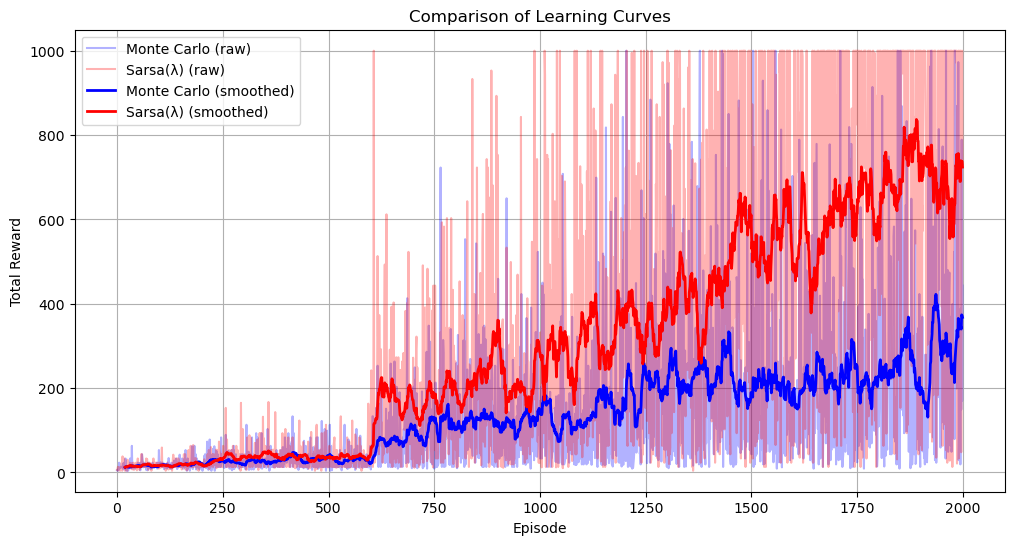


=== Learning Progress Summary ===
Monte Carlo - Last 100 episodes average: 298.77
Sarsa(λ)   - Last 100 episodes average: 689.42
Monte Carlo - Maximum reward: 1000.00
Sarsa(λ)   - Maximum reward: 1000.00

=== Monte Carlo Value Function ===


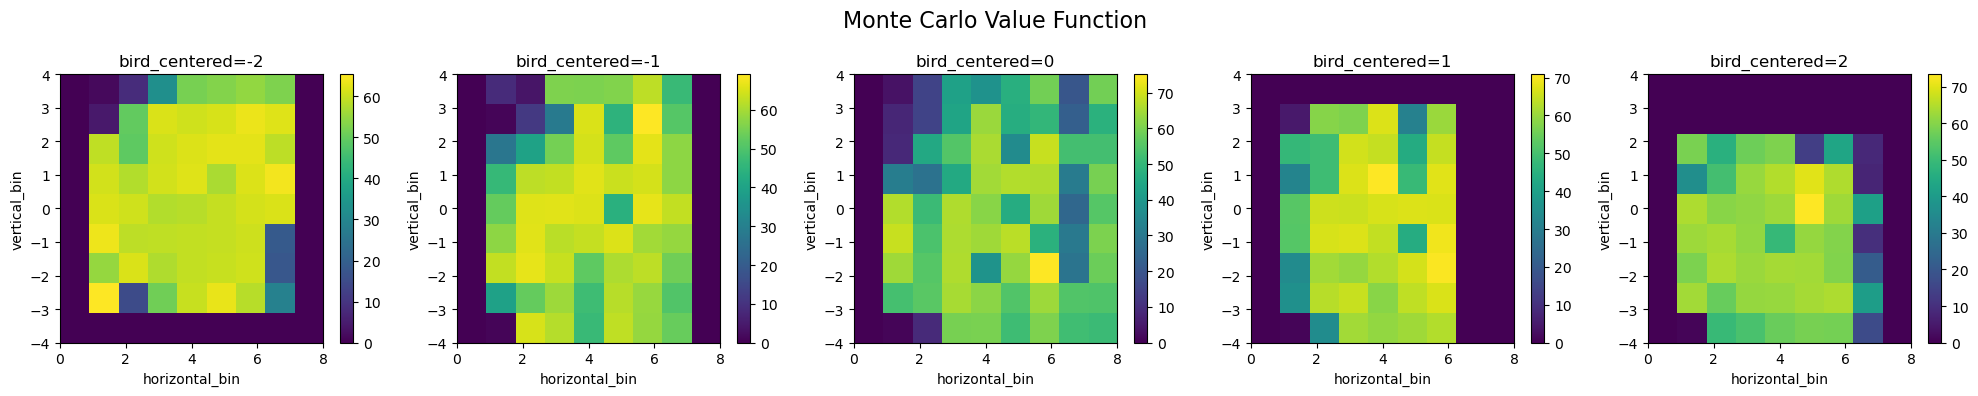


=== Sarsa(λ) Value Function ===


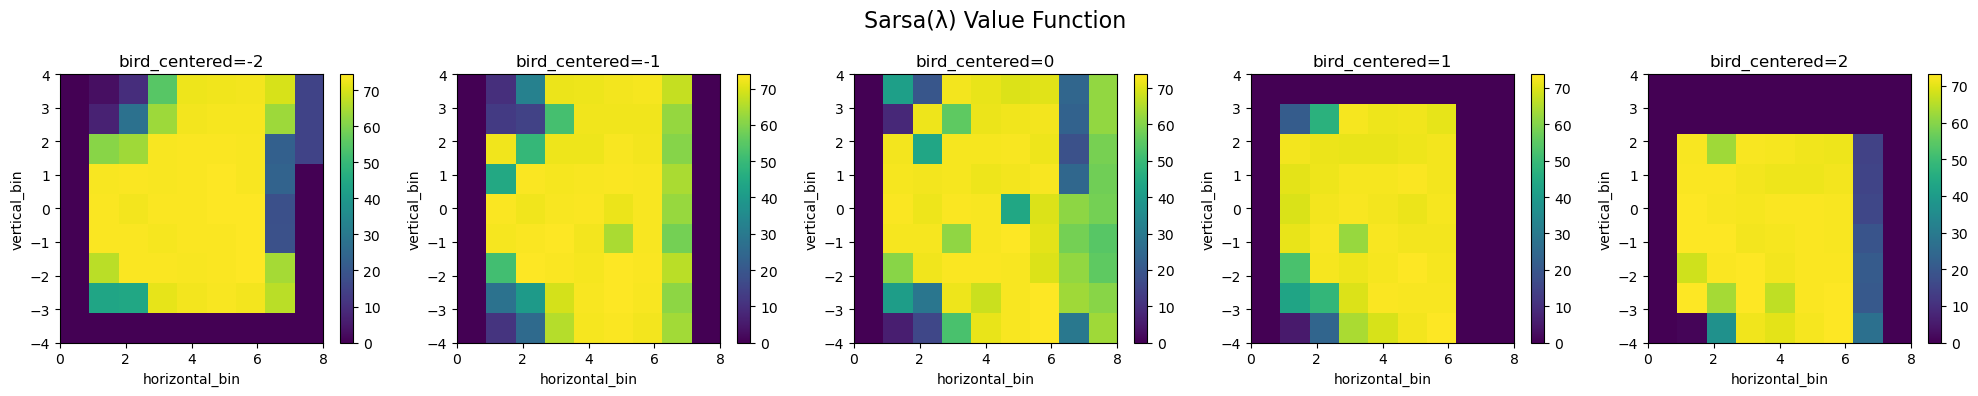


Run complete.


In [31]:
def run_experiment(train_episodes=1500, use_stored_models=False):
    """
    Main function. 
    1) Train MC & Sarsa(λ), 
    2) Show final comparison of learning curves,
    3) Plot each agent's state-value function,
    4) Example param sweep usage (commented by default).
    """
    env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4)

    # 1) Create and train agents (or load existing)
    mc_learner = MonteCarloLearner(
        action_space_size=env.action_space.n,
        discount_factor=0.99,
        exploration_prob=0.2,
        initial_q_val=15.0
    )

    sarsa_learner = SarsaEligibilityLearner(
        action_space_size=env.action_space.n,
        discount_factor=0.99,
        learning_rate=0.1,
        trace_decay=0.9,
        exploration_prob=0.2,
        initial_q_val=15.0
    )

    if use_stored_models:
        try:
            mc_learner.load("monte_carlo_agent_best.pkl")
            print("[MC] Loaded existing model.")
        except:
            print("[MC] No existing model found; training from scratch.")
            use_stored_models = False
        try:
            sarsa_learner.load("sarsa_lambda_agent_best.pkl")
            print("[Sarsa(λ)] Loaded existing model.")
        except:
            print("[Sarsa(λ)] No existing model found; training from scratch.")
            use_stored_models = False

    if not use_stored_models:
        print("\n===== TRAINING MONTE CARLO AGENT =====")
        mc_rewards = mc_learner.train_agent(env, num_episodes=train_episodes)

        env.close()
        env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4)

        print("\n===== TRAINING SARSA(λ) AGENT =====")
        sarsa_rewards = sarsa_learner.train_agent(env, num_episodes=train_episodes)

        # 2) Final comparison
        contrast_learning_progress(mc_rewards, sarsa_rewards)

        # 3) Plot state-value function for each agent
        print("\n=== Monte Carlo Value Function ===")
        plot_state_value_function(mc_learner, "Monte Carlo Value Function")

        print("\n=== Sarsa(λ) Value Function ===")
        plot_state_value_function(sarsa_learner, "Sarsa(λ) Value Function")

    else:
        mc_rewards = []
        sarsa_rewards = []
        print("Using stored models; skipping fresh training. No final reward curves.")

    env.close()
    print("\nRun complete.")
    

if __name__ == "__main__":
    TRAIN_EPISODES = 2000
    USE_STORED_MODELS = False
    run_experiment(train_episodes=TRAIN_EPISODES, use_stored_models=USE_STORED_MODELS)

<Figure size 640x480 with 0 Axes>

[MC] Ep 500/500 | Reward: 133 | Best: 1000
Param=0.2, Performance=417.2


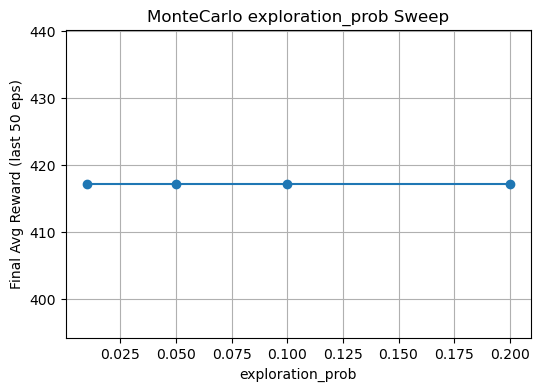

In [24]:
# Example parameter values to try
param_values = [0.01, 0.05, 0.1, 0.2]

# Create a small factory function that returns a new environment
def env_factory():
    return gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4)

print("\n--- Parameter Sweep: Monte Carlo 'exploration_prob' ---")
parameter_sweep_monte_carlo(
    env_fn=env_factory,
    param_name='exploration_prob',   # We override exploration_prob
    param_values=param_values,       # The list of param values to test
    train_episodes=500,              # Train each setting for 500 episodes
    repeats=2                        # Number of runs per setting (for averaging)
)

<Figure size 640x480 with 0 Axes>

[Sarsa(λ)] Ep 500/500 | Reward: 1000 | Best: 1000
Param=0.2, Performance=469.45000000000005


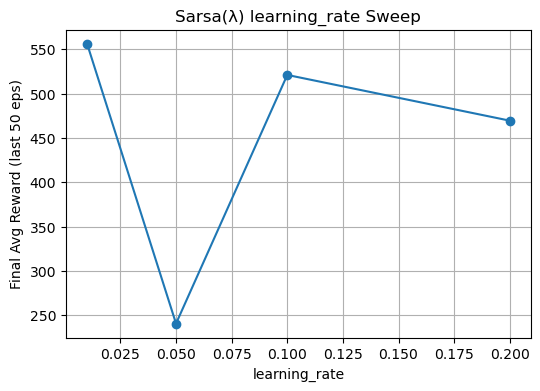

In [25]:
print("\n--- Parameter Sweep: Sarsa(λ) 'learning_rate' ---")
parameter_sweep_sarsa(
    env_fn=env_factory,
    param_name='learning_rate',      # We override learning_rate
    param_values=param_values,
    train_episodes=500,
    repeats=2
)